# Datos descargados de: https://www.pmel.noaa.gov/tao/drupal/disdel/


---
# AUTOR : Michael De La Cruz La Rosa
### 20180176@lamolina.edu.pe
### Michael.dlc.lr@gmail.com
# VIENTOS ZONALES DE LA BOYA UBICADA EN 0°N - 170°W

---

In [73]:
import warnings # Omitir mensajes de advertencia
warnings.filterwarnings("ignore")

In [74]:
# Trabajamos en colab:
from google.colab import drive
drive.mount('/content/drive/')

import os
path = '/content/drive/MyDrive/Colab Notebooks/OCEANOGRAFIA/OCEANOGRAFIA/' # Directorio de trabajo
os.chdir(path)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# VIENTOS:


In [75]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [76]:
uwind = xr.open_dataset(path + 'w0n170w_dy.cdf',drop_variables=['depth','QWS_5401','SWS_6401',
                                                                'QWD_5410',	'SWD_6410','WD_410','WV_423','WS_401']) # ,'lat','lon'
uwind['time'] = pd.date_range(uwind.time[0].values, uwind.time[-1].values, freq = 'D')
uwind

<xarray.Dataset>
Dimensions:  (time: 13030, lat: 1, lon: 1, depth: 1)
Coordinates:
  * time     (time) datetime64[ns] 1988-05-16T12:00:00 ... 2024-01-17T12:00:00
  * lat      (lat) float32 0.0
  * lon      (lon) float32 190.0
Dimensions without coordinates: depth
Data variables:
    WU_422   (time, depth, lat, lon) float32 ...
Attributes:
    platform_code:                0n170w
    site_code:                    0n170w
    wmo_platform_code:            51010
    array:                        TAO/TRITON
    Request_for_acknowledgement:  If you use these data in publications or pr...
    Data_Source:                  Global Tropical Moored Buoy Array Project O...
    File_info:                    Contact: Dai.C.McClurg@noaa.gov
    missing_value:                1e+35
    _FillValue:                   1e+35
    CREATION_DATE:                06:19 19-JAN-2024

In [77]:
# Calculamos la climatología diario (promedio histórico) de 30 años consecutivos
Inicio = '1991-01-01'
Fin = '2020-12-31'
uwind_clim = uwind.sel(time=slice(Inicio, Fin)).groupby('time.dayofyear').mean(dim='time')

# Transformamos a dataframe y nos quedamos con una serie de tiempo (eliminamos 'depth','lat','lon')
uwind_df_clim = uwind_clim.to_dataframe().reset_index()\
.drop(['depth','lat','lon'], axis=1).set_index('dayofyear').reset_index().drop('dayofyear', axis=1)

# Duplicamos y renombramos la columna
uwind_df_clim = pd.concat([uwind_df_clim] * 2, ignore_index=True).rename(columns = {'WU_422' : 'WU_422_Clim'})
uwind_df_clim

,WU_422_Clim
0,-6.157288
1,-5.769274
2,-5.896887
3,-6.063410
4,-5.494972
...,...
727,-5.891370
728,-5.861997
729,-5.569259
730,-5.732070


In [78]:
# round(df_clim.describe().loc[['max', 'min', 'mean', 'std']],2)

In [79]:
# Este paso conviene para quedarnos con los índices de todos los años
uwind_df = uwind.to_dataframe().reset_index().drop(['depth','lat','lon'], axis=1).set_index('time')
uwind_df

,WU_422
time,
1988-05-16 12:00:00,-6.100000
1988-05-17 12:00:00,-6.800000
1988-05-18 12:00:00,-7.400000
1988-05-19 12:00:00,-6.800000
1988-05-20 12:00:00,-6.900000
...,...
2024-01-13 12:00:00,-8.560309
2024-01-14 12:00:00,-7.923369
2024-01-15 12:00:00,-7.852828


In [80]:
YearsUnidos_df = pd.DataFrame()
ListaYears = [1997, 1998, 2016, 2017] # Los años a analizar

for i in range(0, len(ListaYears), 2):
  Col1 = str(ListaYears[i])
  Col2 = str(ListaYears[i+1])
  Cols = uwind_df.loc[Col1:Col2].reset_index().drop(['time'],axis=1)
  YearsUnidos_df = pd.concat([YearsUnidos_df, Cols], axis = 1)\
  .rename(columns = {'WU_422' : f'WU_422_{Col1}_{Col2}'})
YearsUnidos_df

,WU_422_1997_1998,WU_422_2016_2017
0,-5.3,-2.920258
1,-5.3,-1.523138
2,-5.0,-3.032820
3,-4.5,1.008764
4,-3.5,6.274361
...,...,...
726,-9.3,-6.164875
727,-9.3,-7.551150
728,-9.7,-7.205568
729,-6.3,-7.031491


In [81]:
# Ahora vamos unir los dataframe : alt_din_df_clim y YearsUnidos_df
df = pd.concat([uwind_df_clim, YearsUnidos_df], axis = 1)
df

,WU_422_Clim,WU_422_1997_1998,WU_422_2016_2017
0,-6.157288,-5.3,-2.920258
1,-5.769274,-5.3,-1.523138
2,-5.896887,-5.0,-3.032820
3,-6.063410,-4.5,1.008764
4,-5.494972,-3.5,6.274361
...,...,...,...
727,-5.891370,-9.3,-7.551150
728,-5.861997,-9.7,-7.205568
729,-5.569259,-6.3,-7.031491
730,-5.732070,NaN,-5.801790


In [82]:
# round(df.describe().loc[['max', 'min', 'mean', 'std']],2)

In [83]:
import matplotlib.dates as mdates
def Vientos_vs_year(data,year):
  fig, ax = plt.subplots(figsize=(5,6))
  barras = ax.barh(data.index,data.iloc[:,0], color ='cornflowerblue', alpha = 1, label = 'Prom. Histórico',zorder = 10,height=1)
  barras = ax.barh(data.index,data[data.columns[i]],color ='tomato', alpha = 0.5, label = f'Inversión\nAño: {year}',zorder = 10,height=1)
  ax.set_xlabel('Velocidad [m/s]',fontsize=10)
#-----------------------------------------------------------------------------------------
  ax.set_title(f"Vientos Zonales: Promedio Histórico VS Años:{year}\nBoya: {uwind.attrs['site_code']}", fontsize=12, color = 'black')

  ax.xaxis.label.set_color('black')
  ax.yaxis.label.set_color('black')
  ax.tick_params(colors='black')
  ax.grid(linewidth=1, color='silver', linestyle='--',alpha=0.5)
  plt.xticks(fontsize=10)
  plt.yticks(fontsize=10)
  #-----------------------------------------------------------------------------------------
  ax.yaxis.set_major_locator(mdates.MonthLocator())
  ax.yaxis.set_major_formatter(mdates.DateFormatter('%b'))
  plt.axhline(y=365,color ='red', linestyle='--',linewidth=1,zorder = 10)
  #-----------------------------------------------------------------------------------------
  min_value = data.min().min() - 5
  max_value = data.max().max() + 5

  ax.set_xlim(min_value, max_value)
  ax.set_xticks(range(int(min_value), int(max_value)+1, 2))
  ax.invert_yaxis()
  # Agregar leyenda
  ax.legend(loc='best')
  #-----------------------------------------------------------------------------------------
  plt.text(0, -0.12, 'Fuente de datos: NOAA [TAO/TRITON]', fontsize=10, ha='left',
        va='center', color='black', transform=plt.gca().transAxes)

  # fig.savefig(path+ f"UWIND_{uwind.attrs['site_code']}_{year}.jpg",
  #                 transparent = False, pad_inches = 0.1, dpi = 700, bbox_inches = 'tight')
  plt.show()
  plt.close()

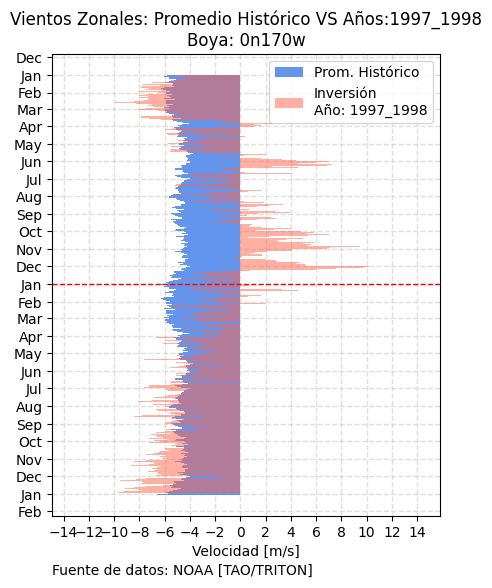

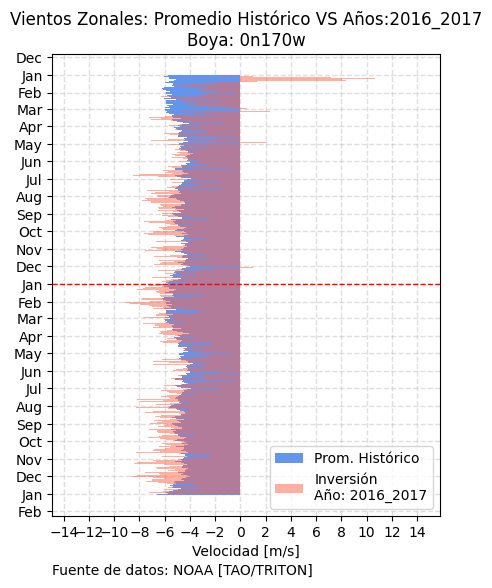

In [84]:
for i in range(1,len(df.columns)):
  Vientos_vs_year(df,df.columns[i].split("WU_422_")[1])

# ANOMALÍAS:

In [85]:
# Calculamos las anomalías diarias
uwind_anom = uwind.groupby('time.dayofyear') - uwind_clim
uwind_anom

<xarray.Dataset>
Dimensions:    (time: 13030, lat: 1, lon: 1, depth: 1)
Coordinates:
  * time       (time) datetime64[ns] 1988-05-16T12:00:00 ... 2024-01-17T12:00:00
  * lat        (lat) float32 0.0
  * lon        (lon) float32 190.0
    dayofyear  (time) int64 137 138 139 140 141 142 143 ... 11 12 13 14 15 16 17
Dimensions without coordinates: depth
Data variables:
    WU_422     (time, depth, lat, lon) float32 -1.967 -3.063 ... -1.409 -1.333

In [86]:
# Transformamos a dataframe y nos quedamos con una serie de tiempo (eliminamos 'depth','lat','lon')
uwind_anom_df = uwind_anom.to_dataframe().reset_index().drop(['depth','lat','lon','dayofyear'], axis=1).set_index('time')
uwind_anom_df

,WU_422
time,
1988-05-16 12:00:00,-1.966936
1988-05-17 12:00:00,-3.062879
1988-05-18 12:00:00,-3.896135
1988-05-19 12:00:00,-2.822573
1988-05-20 12:00:00,-2.871905
...,...
2024-01-13 12:00:00,-2.931560
2024-01-14 12:00:00,-1.974921
2024-01-15 12:00:00,-2.028591


In [87]:
# round(df_Anom.describe().loc[['max', 'min', 'mean', 'std']],2)

In [88]:
Lista_Anom = []
for i in range(0, len(ListaYears), 2):
  Col1 = str(ListaYears[i])
  Col2 = str(ListaYears[i+1])
  Cols = uwind_anom_df.loc[Col1:Col2].reset_index().drop(['time'],axis=1)
  Anom = Cols.rename(columns = {'WU_422' : f'WU_422_Anom_{Col1}_{Col2}'})
  Lista_Anom.append(Anom)
df_Anom = pd.concat(Lista_Anom, axis=1)
df_Anom

,WU_422_Anom_1997_1998,WU_422_Anom_2016_2017
0,0.857287,3.237029
1,0.469274,4.246136
2,0.896887,2.864067
3,1.563410,7.072174
4,1.994972,11.769333
...,...,...
726,-3.408630,-0.522367
727,-3.438004,-1.659780
728,-4.130741,-1.343572
729,-0.567930,-1.462232


In [89]:
def Anom_year(data,year):
  fig, ax = plt.subplots(figsize=(5,6))
  colores = np.where(data[data.columns[i]]>0, 'tomato', 'cornflowerblue')
  etiquetas = {'tomato': 'Debilitamiento', 'cornflowerblue': 'Intensificación'}
  barras = ax.barh(data.index,data[data.columns[i]],color =colores, alpha = 1,zorder = 10,height=1)

  ax.set_title(f"Anomalías de Viento Zonal: Año {year}\nBoya: {uwind.attrs['site_code']}", fontsize=12, color = 'black')

  ax.xaxis.label.set_color('black')
  ax.yaxis.label.set_color('black')
  ax.tick_params(colors='black')
  ax.grid(linewidth=1, color='silver', linestyle='--',alpha=0.5)
  ax.yaxis.set_major_locator(mdates.MonthLocator())
  ax.yaxis.set_major_formatter(mdates.DateFormatter('%b'))
  plt.axhline(y=365,color ='green', linestyle='--',linewidth=1,zorder = 10)

  ax.grid(linewidth=1, color='silver', linestyle='--',alpha=0.5)
  plt.xticks(fontsize=10)
  plt.yticks(fontsize=10)
  #-----------------------------------------------------------------------------------------
  min_value = data.min().min() - 5
  max_value = data.max().max() + 5

  ax.set_xlim(min_value, max_value)
  ax.set_xticks(range(int(min_value), int(max_value)+1, 2))
  ax.invert_yaxis()
  #-----------------------------------------------------------------------------------------
  # fig.savefig(path + f"UWIND_Anom_{uwind.attrs['site_code']}_{year}.jpg",
  #                 transparent = False, pad_inches = 0.1, dpi = 700, bbox_inches = 'tight')
  # Agregar leyenda
  handles = [plt.Rectangle((0,0),1,1, color=color) for color in etiquetas.keys()]
  ax.legend(handles, etiquetas.values(), loc='best')
  plt.show()
  plt.close()

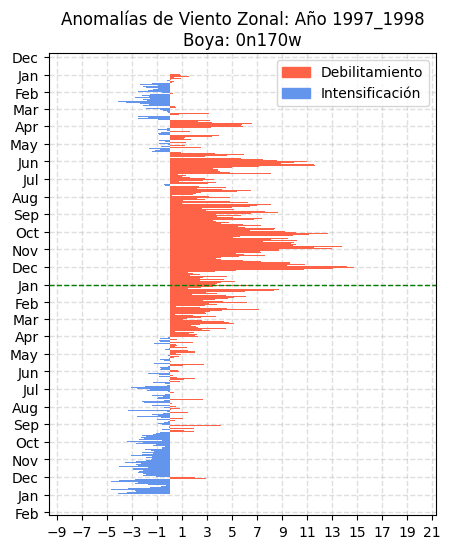

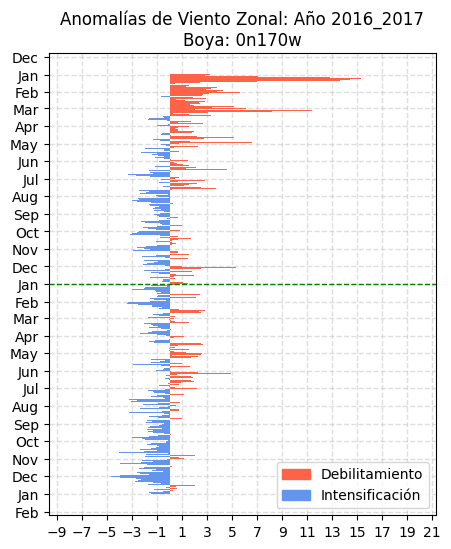

In [90]:
for i in range(0,len(df_Anom.columns)):
  Anom_year(df_Anom,df_Anom.columns[i].split("WU_422_Anom_")[1])



---
# Los datos utilizados se encuentran en el siguiente link:
https://drive.google.com/drive/folders/1zo4Uq3XS9KKn_I2Ei1J_FiYu4QryQnNt



---